In [1]:
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
from os.path import basename

In [2]:
# Add the python path to the folder containing some custom packages.
import sys
sys.path.insert(0, "../")
from _utils import *

In [3]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

# Analysis

In [4]:
#PROJECT_ROOT = "./RESULTS/Review 2"
PROJECT_ROOT = "./RESULTS/2° Analysis"

NAME_ANALYSIS = basename(PROJECT_ROOT)

## Configuration

In [5]:
# Load corresponding simulations (hyper-parameter tuning + forecasting) for each country.
COUNTRIES = ["Yemen", "Syria", "Burkina Faso", "Nigeria", "Mali", "Cameroon"] 

In [6]:
for country in COUNTRIES:
    print(country)
    # Load forecasting results for each split.
    xls = pd.ExcelFile(f"{PROJECT_ROOT}/{country}/standard/out_test/forecast.xlsx")

    for i, split in enumerate(xls.sheet_names[1:]):
        forecast_split = pd.read_excel(xls, split, index_col = 0, header = [0, 1, 2])
        print(f"{split}: {forecast_split.index[0].date()} - {forecast_split.index[-1].date()}")

Yemen
Split 1: 2021-03-01 - 2021-03-30
Split 2: 2021-04-01 - 2021-04-30
Split 3: 2021-05-01 - 2021-05-30
Split 4: 2021-06-01 - 2021-06-30
Split 5: 2021-07-01 - 2021-07-30
Split 6: 2021-08-01 - 2021-08-30
Split 7: 2021-09-01 - 2021-09-30
Split 8: 2021-10-01 - 2021-10-30
Split 9: 2021-11-01 - 2021-11-30
Split 10: 2021-12-01 - 2021-12-30
Split 11: 2022-01-01 - 2022-01-30
Split 12: 2022-02-01 - 2022-03-02
Split 13: 2022-03-01 - 2022-03-30
Syria
Split 1: 2021-05-01 - 2021-05-30
Split 2: 2021-06-01 - 2021-06-30
Split 3: 2021-07-01 - 2021-07-30
Split 4: 2021-08-01 - 2021-08-30
Split 5: 2021-09-01 - 2021-09-30
Split 6: 2021-10-01 - 2021-10-30
Split 7: 2021-11-01 - 2021-11-30
Split 8: 2021-12-01 - 2021-12-30
Split 9: 2022-01-01 - 2022-01-30
Split 10: 2022-02-01 - 2022-03-02
Burkina Faso
Split 1: 2021-09-01 - 2021-09-30
Split 2: 2021-10-01 - 2021-10-30
Split 3: 2021-11-01 - 2021-11-30
Split 4: 2021-12-01 - 2021-12-30
Split 5: 2022-01-01 - 2022-01-30
Split 6: 2022-02-01 - 2022-03-02
Split 7: 2022

### Select one of these options

In [7]:
# 2° Analysis - Partial - 5 splits.
# Select what splits to consider for the current analysis.
SELECT_SPLITS = {"Yemen": [8, 9, 10, 11, 12], 
                 "Syria": [6, 7, 8, 9, 10], 
                 "Burkina Faso": [2, 3, 4, 5, 6], 
                 "Nigeria": [1, 2, 3, 4, 5], 
                 "Mali": [1, 2, 3, 4, 5], 
                 "Cameroon": [1, 2, 3, 4, 5]}
TYPE_ANALYSIS = "partial_5_splits"

## Metrics

In [8]:
all_results = {}
for i, country in enumerate(COUNTRIES):
    xls = pd.ExcelFile(f"{PROJECT_ROOT}/{country}/standard/out_test/forecast.xlsx")
    fcg = pd.read_excel(xls, "FCG", index_col = 0, header = [1, 2])
    
    selected_splits = ["Split {}".format(s) for s in SELECT_SPLITS[country]]
    # Values forecasting.
    values = {}
    fcg_train = {}    
    for split in selected_splits:
        forecast_split = pd.read_excel(xls, split, index_col = 0, header = [1, 2])
        fcg_split = fcg.loc[:forecast_split.index[0]-pd.Timedelta("1 day")]
        forecast_split = forecast_split.reset_index(drop = True)
        values[split] = forecast_split
        fcg_train[split] = fcg_split
    values = pd.concat(values, axis = 1)
    values.index = np.arange(1, len(values)+1)
    # Load training shapes.
    training_shape = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/training_shapes.csv", header = [0, 1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    training_shape = training_shape[selected_splits] # Filter
    # Load mse losses (model and naive) based on prediction horizons.
    loss_h = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1])
    loss_h = loss_h.droplevel(level = 0, axis = 0)
    loss_h = loss_h[selected_splits] # Filter
    # Load r2 (model and naive) based on prediction horizons.
    r2_h = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])
    r2_h = r2_h.droplevel(level = 0, axis = 1)
    r2_h = r2_h[selected_splits] # Filter
    # Variance (constant for each prediction horizon).
    variance = values.xs("FCG", axis = 1, level = 2, drop_level = False)
    variance = variance.apply(np.var)
    variance = variance.unstack([0, 1]).reset_index(drop = True)
    variance.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["variance"]), variance.columns)), 
                                                 names = ["Split", "AdminStrata", "Type"])
    variance = variance.groupby(axis = 1, level = [0, 2]).mean() # Average across adminstratas.
    variance = variance.loc[variance.index.repeat(len(values))]
    variance.index = values.index
    # Difference between naive and actual values.
    difference_naive = values.drop("Forecast", axis = 1, level = 2).stack([0, 1])
    difference_naive["abs_diff_naive"] = np.abs(difference_naive["FCG"] - difference_naive["Naive"])
    difference_naive = difference_naive.drop(["FCG", "Naive"], axis = 1)
    difference_naive = difference_naive.unstack([1, 2]).groupby(axis = 1, level = [0, 1]).mean()
    difference_naive = difference_naive.reorder_levels([1, 0], axis = 1)
    # Variance fcg training.
    variance_train_fcg = pd.concat(fcg_train, axis = 1)
    variance_train_fcg = variance_train_fcg.apply(lambda x: np.var(x.dropna()))
    variance_train_fcg = variance_train_fcg.unstack([0, 1]).reset_index(drop = True)
    variance_train_fcg.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["variance_train_fcg"]), 
                                                                    variance_train_fcg.columns)), 
                                                         names = ["Split", "AdminStrata", "Type"])
    variance_train_fcg = variance_train_fcg.groupby(axis = 1, level = [0, 2]).mean() # Average across adminstratas.
    variance_train_fcg = variance_train_fcg.loc[variance_train_fcg.index.repeat(len(values))]
    variance_train_fcg.index = values.index

    # Concatenation.
    results = pd.concat([training_shape, loss_h, r2_h, variance, difference_naive, variance_train_fcg], axis = 1)
    results = results.sort_index(axis = 1)
    
    # Select some prediction horizon for visualization.
    #results = results.loc[[7, 14, 21, 28]]
        
    all_results[country] = results

In [9]:
df = pd.concat(all_results, axis = 1)
df.columns.names = ["Country", "Split", "Info"]
df.index.name = "Prediction horizon"
df.head()

Country                     Yemen                                          \
Split                    Split 10                                           
Info               abs_diff_naive mse_model mse_naive  r2_model  r2_naive   
Prediction horizon                                                          
1                        0.509992  0.518303  0.367274  0.995687  0.996944   
2                        0.760622  1.373076  0.832761  0.988031  0.992741   
3                        0.873176  1.897897  1.267211  0.982768  0.988494   
4                        1.106535  2.355250  1.711000  0.978716  0.984538   
5                        1.159080  2.796305  2.312092  0.974632  0.979025   

Country                                                          \
Split                                                             
Info               training points  variance variance_train_fcg   
Prediction horizon                                                
1                            23840  5.658171          43.160332   
2                            23820  5.658171          43.160332   
3                            23800  5.658171          43.160332   
4                            23780  5.658171          43.160332   
5                            23760  5.658171          43.160332   

Country                                      ...   Cameroon  \
Split                    Split 11            ...    Split 4   
Info               abs_diff_naive mse_model  ...   variance   
Prediction horizon                           ...              
1                        0.480472  0.353159  ...  16.391857   
2                        0.684453  0.717653  ...  16.391857   
3                        0.982334  1.901898  ...  16.391857   
4                        1.274339  3.808049  ...  16.391857   
5                        1.492861  3.935916  ...  16.391857   

Country                                                                   \
Split                                        Split 5                       
Info               variance_train_fcg abs_diff_naive mse_model mse_naive   
Prediction horizon                                                         
1                            125.7083       1.199424  1.762951  1.856495   
2                            125.7083       1.398811  2.518082  2.793372   
3                            125.7083       1.607944  3.218842  3.161434   
4                            125.7083       2.058927  6.260548  5.840556   
5                            125.7083       2.317895  8.261041  7.225477   

Country                                                           \
Split                                                              
Info                r2_model  r2_naive training points  variance   
Prediction horizon                                                 
1                   0.972654  0.971203            9330  7.586633   
2                   0.968053  0.964560            9320  7.586633   
3                   0.962970  0.963630            9310  7.586633   
4                   0.927867  0.932706            9300  7.586633   
5                   0.911688  0.922758            9290  7.586633   

Country                                
Split                                  
Info               variance_train_fcg  
Prediction horizon                     
1                          129.417677  
2                          129.417677  
3                          129.417677  
4                          129.417677  
5                          129.417677  

[5 rows x 240 columns]

In [10]:
df.to_csv(f"{PROJECT_ROOT}/variance_{TYPE_ANALYSIS}.csv")

## Weighted average and standard deviation.

In [11]:
# Compute difference between loss model and naive.
results = df.stack(["Country", "Split"])
results["mse_difference"] = results["mse_naive"] - results["mse_model"]
results["mse_ratio"] = results["mse_naive"] / results["mse_model"]

In [12]:
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    # Fast and numerically precise:
    variance = np.average((values-average)**2, weights=weights)
    return (average, np.sqrt(variance))

In [13]:
def get_w_avg_mse_diff(x, target, weight):
    # Weigthed average.
    w_avg_mse_diff, w_std_mse_diff = weighted_avg_and_std(x[target], x[weight])
    ci = 2.776*w_std_mse_diff/np.sqrt(5) #t_{4,0.025}=2.776
    # Average training points.
    training_points = np.mean(x["training points"])
    return pd.Series([w_avg_mse_diff, w_std_mse_diff, ci, training_points], 
                     index = ["w_avg_mse_diff", "w_std_mse_diff", "ci", "training_points"])

In [14]:
# Compute weighted average and std.
results_w = results.groupby(axis = 0, level = ["Country", "Prediction horizon"]).apply(lambda x: get_w_avg_mse_diff(x, "mse_difference", "variance"))
results_w = results_w.unstack(["Country"]).reorder_levels([1, 0], axis = 1).sort_index(axis = 1)
results_w.head()

Country            Burkina Faso                                                \
                             ci training_points w_avg_mse_diff w_std_mse_diff   
Prediction horizon                                                              
1                      0.298727         10444.2      -0.059868       0.240624   
2                      0.424305         10431.2       0.189982       0.341777   
3                      0.855162         10418.2      -0.074120       0.688833   
4                      1.129133         10405.2       0.025468       0.909517   
5                      2.465751         10392.2      -0.393376       1.986162   

Country             Cameroon                                                \
                          ci training_points w_avg_mse_diff w_std_mse_diff   
Prediction horizon                                                           
1                   0.353748          8714.0      -0.259768       0.284944   
2                   0.443197          8704.0       0.204044       0.356995   
3                   0.762778          8694.0       0.232920       0.614417   
4                   1.009215          8684.0       0.227792       0.812922   
5                   2.003490          8674.0       0.652521       1.613811   

Country                  Mali                  ...        Nigeria  \
                           ci training_points  ... w_avg_mse_diff   
Prediction horizon                             ...                  
1                    1.025327          5315.8  ...      -0.003430   
2                    0.933811          5308.8  ...       0.048998   
3                    5.747884          5301.8  ...      -0.006446   
4                   11.930940          5294.8  ...      -0.080144   
5                   18.885416          5287.8  ...      -1.286893   

Country                               Syria                                 \
                   w_std_mse_diff        ci training_points w_avg_mse_diff   
Prediction horizon                                                           
1                        0.179677  0.318288         14034.8       0.057330   
2                        0.604935  0.880233         14022.8      -0.497566   
3                        0.970053  1.719655         14010.8      -0.725258   
4                        2.021314  3.364501         13998.8      -1.133517   
5                        1.851672  5.322340         13986.8      -1.484167   

Country                               Yemen                                 \
                   w_std_mse_diff        ci training_points w_avg_mse_diff   
Prediction horizon                                                           
1                        0.256381  0.281404         23848.0      -0.179280   
2                        0.709028  0.228357         23828.0      -0.189676   
3                        1.385182  0.294982         23808.0      -0.225043   
4                        2.710105  0.616838         23788.0      -0.373053   
5                        4.287144  0.646308         23768.0      -0.039281   

Country                            
                   w_std_mse_diff  
Prediction horizon                 
1                        0.226671  
2                        0.183941  
3                        0.237608  
4                        0.496863  
5                        0.520601  

[5 rows x 24 columns]

## Figures

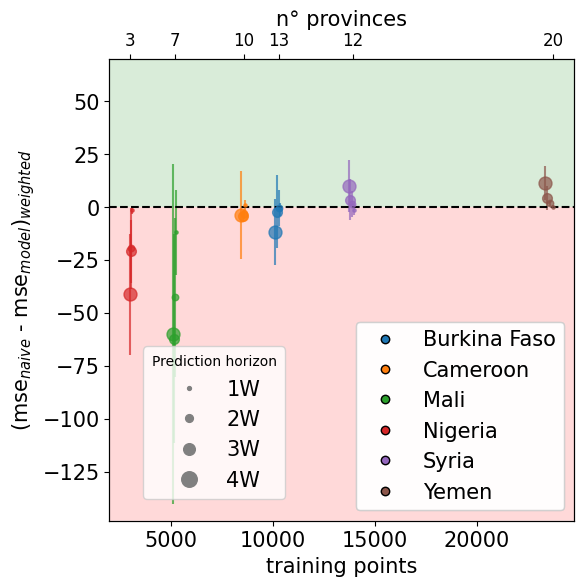

In [15]:
fig, axs = plt.subplots(figsize = (6, 6))

CURRENT_COUNTRIES = list(results_w.columns.get_level_values("Country").unique())

n_provinces = []
for i, country in enumerate(CURRENT_COUNTRIES):
    tmp_results = results_w[country]
    # Select some prediction horizon for visualiztion.
    tmp_results = tmp_results.loc[[7, 14, 21, 28]]
    
    # Provinces.
    with open(f"{PROJECT_ROOT}/{country}/standard/provinces_considered", "rb") as fp:
        provinces = pickle.load(fp)
    n_provinces.append((len(provinces[country]), tmp_results["training_points"].mean().mean()))

    for j in range(len(tmp_results)):
        axs.errorbar(tmp_results.iloc[j]["training_points"], tmp_results.iloc[j]["w_avg_mse_diff"],
                     yerr = tmp_results.iloc[j]["w_std_mse_diff"], marker = "o", linestyle = "none", 
                     color = sns.color_palette("tab10")[i], markersize = tmp_results.index[j]/3, 
                     alpha = 0.7)

# Add 0 line.
axs.axhline(y = 0, color = "black", linestyle = "--")

ax2 = axs.twiny()
ax2.plot([x[1] for x in n_provinces], np.ones(len(n_provinces)), alpha = 0) # Create a dummy plot
xticks = ax2.get_xticks()
ax2.set_xticks([x[1] for x in n_provinces])
ax2.set_xticklabels([str(x[0]) for x in n_provinces], fontdict = {'fontsize': 12})
ax2.set_xlabel("n° provinces")
 
# Legend.
h = [plt.plot([],[], color = sns.color_palette("tab10")[i], marker = "o", ls = "", markeredgewidth = 1, 
              markeredgecolor = "black")[0] for i, country in enumerate(CURRENT_COUNTRIES)]
h = plt.legend(handles = h, labels = CURRENT_COUNTRIES, loc = "lower right")

h1 = [plt.plot([],[], color = "gray", marker = "o", ms = i, ls = "")[0] for i in tmp_results.index.values/2.5]
axs.legend(handles = h1, labels = ["1W", "2W", "3W", "4W"], loc = "upper right", bbox_to_anchor = (0.4,0.4), 
           title = "Prediction horizon")

plt.gca().add_artist(h)

axs.set_xlabel("training points")
axs.set_ylabel("(mse$_{naive}$ - mse$_{model}$)$_{weighted}$")

a = (axs.get_xlim()[0], axs.get_xlim()[1])
b = (axs.get_ylim()[0], 70)

axs.fill_between(np.arange(a[0], a[1]), 0, b[1], facecolor = "green", alpha = 0.15)
axs.fill_between(np.arange(a[0], a[1]), 0, b[0], facecolor = "red", alpha = 0.15)

axs.set_xlim(a)
axs.set_ylim((b[0], 70))

fig.savefig(f"./IMAGES/{NAME_ANALYSIS}/w_all_countries_{TYPE_ANALYSIS}.png" , bbox_inches = "tight", dpi = 300)

## Performance country

In [16]:
CURRENT_COUNTRY = "Syria"

DIR_RESULTS = f"{PROJECT_ROOT}/{CURRENT_COUNTRY}"
CURRENT_SELECT_SPLITS = SELECT_SPLITS[CURRENT_COUNTRY]

In [17]:
# Load the training shapes for each split and prediction horizon.
training_shape = pd.read_csv(DIR_RESULTS + "/standard/out_test/training_shapes.csv", header = [0, 1], index_col = 0)
training_shape = training_shape[["Split " + str(s) for s in CURRENT_SELECT_SPLITS]] # Filter

# Load the losses for each split and province (model and naive).
loss_sites = pd.read_csv(DIR_RESULTS + "/standard/out_test/loss_sites.csv", index_col = [0, 1], header = [0, 1])
loss_sites = loss_sites[["Split " + str(s) for s in CURRENT_SELECT_SPLITS]] # Filter

# Load the losses for each split and prediction horizon (model and naive).
loss_h = pd.read_csv(DIR_RESULTS + "/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1])
loss_h = loss_h[["Split " + str(s) for s in CURRENT_SELECT_SPLITS]] # Filter

# Load the r2 for each split and prediction horizon (model and naive).
r2_results = pd.read_csv(DIR_RESULTS + "/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])
r2_results = r2_results.loc[:, r2_results.columns.get_level_values(1).isin(["Split " + str(s) for s in CURRENT_SELECT_SPLITS])] # Filter

In [18]:
r2_results.rename({"r2_model": "model", "r2_naive": "naive"}, axis = 1, level = 2, inplace = True)
loss_h.rename({"mse_model": "model", "mse_naive": "naive"}, axis = 1, level = 1, inplace = True)

In [19]:
loss_h_diff = loss_h.loc[CURRENT_COUNTRY].stack(["Split"])
loss_h_diff["mse_difference"] = loss_h_diff["naive"] - loss_h_diff["model"]

### Average and standard deviation

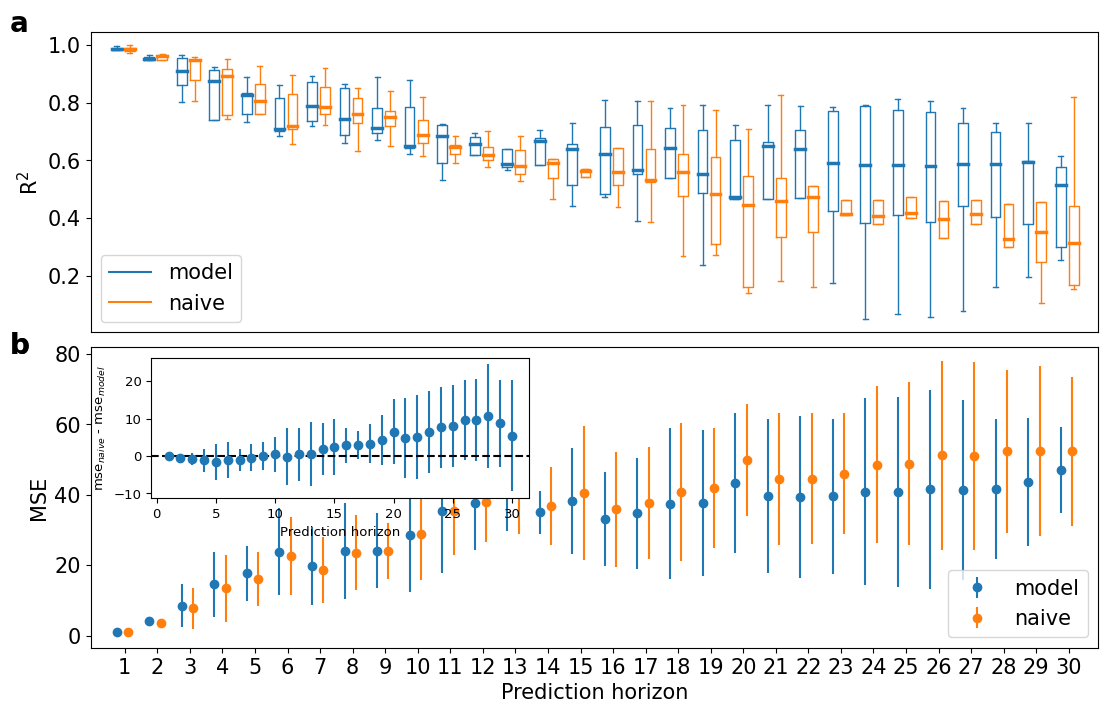

In [20]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (13, 8), sharex = True)    
fig.subplots_adjust(hspace = .05)

## Loss of each split as function of the prediction horizon.

colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]]

## r2 scores

SPLITS = r2_results.columns.get_level_values(1).unique()
   
plot_r2_box_plot(r2_results[CURRENT_COUNTRY], axs[0], "model", "naive")
axs[0].tick_params(labelright = False)
axs[0].text(-0.08, 1., "a", transform = axs[0].transAxes, 
            size = 20, weight='bold')
#axs[0].set_ylim([, 1])
    
## Total loss over the splits as function of the prediction horizon.
        
# Mean and standard deviation.

SPLITS = loss_h.columns.get_level_values(0).unique()
MODELS = loss_h.columns.get_level_values(1).unique()

for i, m in enumerate(MODELS):  
    value = loss_h.loc[CURRENT_COUNTRY].xs(m, axis = 1, level = 1, drop_level = False)
    value_statistic = value.agg([np.mean, np.std], axis = 1)
    value_statistic.columns = ["mean", "std"]

    # Plot.
    if i == 0:
        trans1 = Affine2D().translate(-0.5, 0.0) + axs[1].transData
        axs[1].errorbar(axs[0].get_xticks(), value_statistic["mean"], yerr = value_statistic["std"], marker = "o", 
                     linestyle = "none", transform = trans1, c = colors[i], label = m)
    else:
        trans2 = Affine2D().translate(+0.2, 0.0) + axs[1].transData
        axs[1].errorbar(axs[0].get_xticks(), value_statistic["mean"], yerr = value_statistic["std"], marker = "o", 
                     linestyle = "none", transform = trans2, c = colors[i], label = m)

    # Set attributes of the plot.
    axs[1].legend(loc = "lower right")
    axs[1].set_xlabel("Prediction horizon")
    axs[1].set_ylabel("MSE")

    axs[1].text(-0.08, 0.98, "b", transform = axs[1].transAxes, 
            size = 20, weight='bold')
    
# Mean and std difference losses.

inset_ax = inset_axes(axs[1],
                    width="30%", # width = 30% of parent_bbox
                    height=1.4, # height : 1 inch
                    loc=2, bbox_to_anchor=(0.05,1-0.2,1.25,.2), bbox_transform=axs[1].transAxes)
res_loss_h_diff = loss_h_diff.groupby(axis = 0, level = "Prediction horizon").agg(avg_mse_difference = ("mse_difference", np.mean), 
                                                                                  std_mse_difference = ("mse_difference", np.std))

inset_ax.errorbar(res_loss_h_diff.index, res_loss_h_diff["avg_mse_difference"], 
                  yerr = res_loss_h_diff["std_mse_difference"], 
                  marker = "o", linestyle = "none", c = colors[0])
inset_ax.axhline(y = 0, color = "black", linestyle = "--")
#inset_ax.set_xticks(np.arange(1, 31));
inset_ax.tick_params(axis="x", labelsize=9.5)
inset_ax.tick_params(axis="y", labelsize=9.5)
inset_ax.set_xlabel("Prediction horizon", fontsize=9.5)
inset_ax.set_ylabel("mse$_{naive}$ - mse$_{model}$", fontsize=9.5)
        
axs[0].axes.get_xaxis().set_visible(False)

fig.savefig(f"./IMAGES/{NAME_ANALYSIS}/inset_{CURRENT_COUNTRY}_{TYPE_ANALYSIS}.png" , bbox_inches = "tight", dpi = 300)

### Weighted average and standard deviation

In [21]:
def get_w_avg_mse_diff(x, target, weight):
    # Weigthed average.
    w_avg_mse_diff, w_std_mse_diff = weighted_avg_and_std(x[target], x[weight])
    ci = 2.776*w_std_mse_diff/np.sqrt(5) #t_{4,0.025}=2.776
    return pd.Series([w_avg_mse_diff, w_std_mse_diff, ci], 
                     index = ["w_avg_mse_diff", "w_std_mse_diff", "ci"])

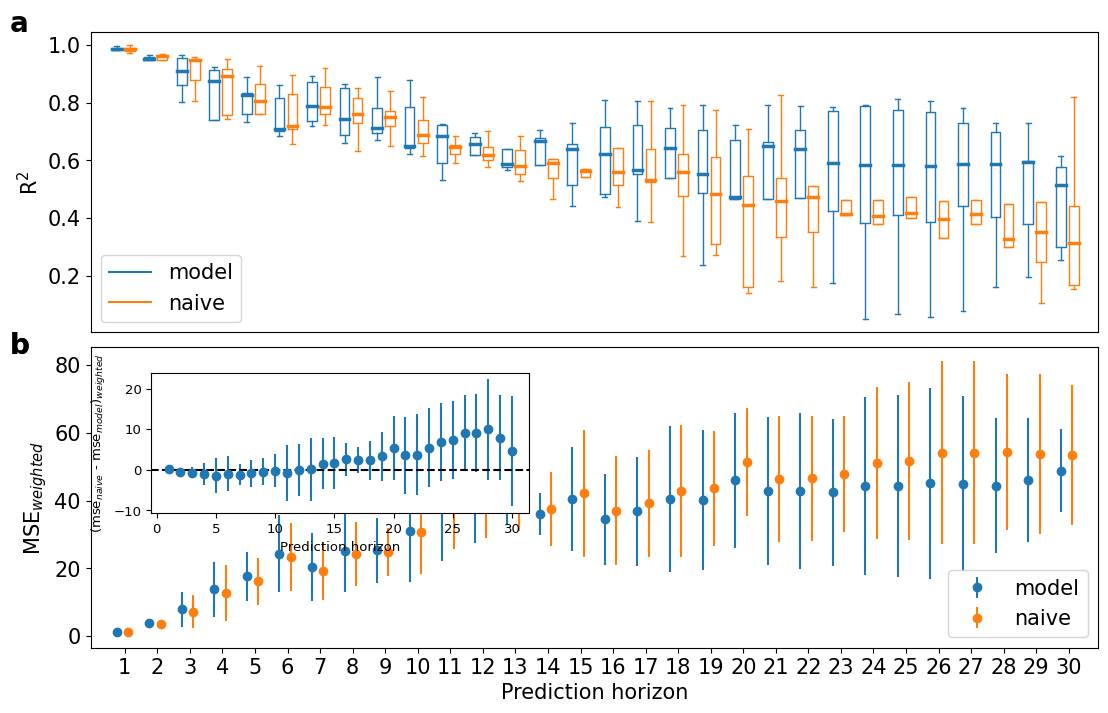

In [22]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize = (13, 8), sharex = True)    
fig.subplots_adjust(hspace = .05)

## Loss of each split as function of the prediction horizon.

colors = [sns.color_palette("tab10")[0], sns.color_palette("tab10")[1]]

## r2 scores

SPLITS = r2_results.columns.get_level_values(1).unique()
   
plot_r2_box_plot(r2_results[CURRENT_COUNTRY], axs[0], "model", "naive")
axs[0].tick_params(labelright = False)
axs[0].text(-0.08, 1., "a", transform = axs[0].transAxes, 
            size = 20, weight='bold')
#axs[0].set_ylim([, 1])
    
## Total loss over the splits as function of the prediction horizon.
        
# Weighted mean and standard deviation.

SPLITS = loss_h.columns.get_level_values(0).unique()
MODELS = loss_h.columns.get_level_values(1).unique()

for i, m in enumerate(MODELS):  
    value = loss_h.loc[CURRENT_COUNTRY].xs(m, axis = 1, level = 1, drop_level = False)
    # Variance.
    variance = results.xs(CURRENT_COUNTRY, axis = 0, level = "Country")[["variance"]].unstack("Split")
    variance = variance.reorder_levels([1, 0], axis = 1)

    tmp_loss = pd.concat([variance, value], axis = 1).sort_index(axis = 1).stack("Split")

    # Compute weighted average and std.
    value_statistic = tmp_loss.groupby(axis = 0, level = ["Prediction horizon"]).apply(lambda x: get_w_avg_mse_diff(x, m, "variance"))

    # Plot.
    if i == 0:
        trans1 = Affine2D().translate(-0.5, 0.0) + axs[1].transData
        axs[1].errorbar(axs[0].get_xticks(), value_statistic["w_avg_mse_diff"], yerr = value_statistic["w_std_mse_diff"], marker = "o", 
                     linestyle = "none", transform = trans1, c = colors[i], label = m)
    else:
        trans2 = Affine2D().translate(+0.2, 0.0) + axs[1].transData
        axs[1].errorbar(axs[0].get_xticks(), value_statistic["w_avg_mse_diff"], yerr = value_statistic["w_std_mse_diff"], marker = "o", 
                     linestyle = "none", transform = trans2, c = colors[i], label = m)

    # Set attributes of the plot.
    axs[1].legend(loc = "lower right")
    axs[1].set_xlabel("Prediction horizon")
    axs[1].set_ylabel("MSE$_{weighted}$")

    axs[1].text(-0.08, 0.98, "b", transform = axs[1].transAxes, 
            size = 20, weight='bold')
    
# Weighted mean and std difference losses.
variance = results.xs(CURRENT_COUNTRY, axis = 0, level = "Country")[["variance"]]
loss_h_diff_var = pd.concat([loss_h_diff, variance], axis = 1)
res_loss_h_diff = loss_h_diff_var.groupby(axis = 0, level = ["Prediction horizon"]).apply(lambda x: get_w_avg_mse_diff(x, "mse_difference", "variance"))

inset_ax = inset_axes(axs[1],
                    width="30%", # width = 30% of parent_bbox
                    height=1.4, # height : 1 inch
                    loc=2, bbox_to_anchor=(0.05,1-0.25,1.25,.2), bbox_transform=axs[1].transAxes)

inset_ax.errorbar(res_loss_h_diff.index, res_loss_h_diff["w_avg_mse_diff"], 
                  yerr = res_loss_h_diff["w_std_mse_diff"], 
                  marker = "o", linestyle = "none", c = colors[0])
inset_ax.axhline(y = 0, color = "black", linestyle = "--")
#inset_ax.set_xticks(np.arange(1, 31));
inset_ax.tick_params(axis="x", labelsize=9.5)
inset_ax.tick_params(axis="y", labelsize=9.5)
inset_ax.set_xlabel("Prediction horizon", fontsize=9.5)
inset_ax.set_ylabel("(mse$_{naive}$ - mse$_{model}$)$_{weighted}$", fontsize=9.5)
        
axs[0].axes.get_xaxis().set_visible(False)

fig.savefig(f"./IMAGES/{NAME_ANALYSIS}/w_inset_{CURRENT_COUNTRY}_{TYPE_ANALYSIS}.png" , bbox_inches = "tight", dpi = 300)